# Installing Pre-requisties

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.3 MB/s eta 0:00:00


In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=817b544f45635064bac3cf3cde38a4b57f66e8f6f1b15dfe8aa67963da7c69d2
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


# Importing essentials libraries

In [3]:
import random

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from matplotlib import pyplot as plt
from torchmetrics.classification import BinaryConfusionMatrix
import medmnist
from medmnist import BreastMNIST
from medmnist import INFO, Evaluator

In [4]:
data_flag = 'breastmnist'
download = True
NUM_EPOCHS = 500
BATCH_SIZE = 128
lr = 0.001

In [5]:
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

# Preprocessing

In [6]:
IMAGE_SIZE = 64

data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])


# Loading Data

In [7]:
train_dataset = BreastMNIST(split='train', transform=data_transform, download=download)
val_dataset = BreastMNIST(split='val', transform=data_transform, download=download)
test_dataset = BreastMNIST(split='test', transform=data_transform, download=download)


100%|██████████| 559580/559580 [00:00<00:00, 1038520.31it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


# Convert to Dataloader

In [8]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

In [33]:
len(val_dataset)

78

# Resnet model loading

In [6]:
ResNet18Model = resnet18(weights=ResNet18_Weights.DEFAULT)
ResNet18Model.fc = nn.Linear(in_features=ResNet18Model.fc.in_features, out_features=2)
for lay in ResNet18Model.children():
    lay.requires_grad = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ResNet18Model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 27.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Plot random Images

In [22]:
randomlist = random.sample(range(0, len(train_dataset)), 40)

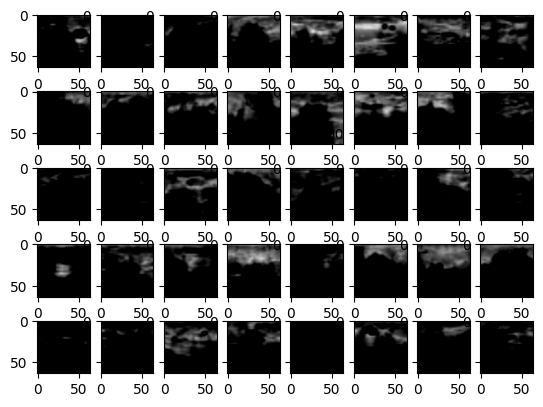

In [27]:
fig, axs = plt.subplots(5, 8)
for i in range(40):
    axs[i//8][i%8].imshow(train_dataset[randomlist[i]][0].permute(1, 2, 0))

In [9]:
optimizer = optim.SGD(ResNet18Model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [10]:
def train_epoch(model, train_loader, device, optimizer, loss_fn):
    model.train()
    train_losses = []
    train_acc = 0
    total_train = 0

    train_loop = tqdm(train_loader, leave=True)
    for batch in train_loop:
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        input_img = batch[0].to(device)
        out_class = batch[1].type(torch.LongTensor).to(device)

        output = model(input_img)
        loss = loss_fn(output.contiguous().view(output.size(0), -1), out_class.view(-1))
        predicted = torch.argmax(output.data, dim=1)
        total_train += out_class.size(0)
        train_acc += (predicted == out_class.flatten()).sum().item()

        loss.backward()
        optimizer.step()

        train_loop.set_description('Train')
        train_loop.set_postfix(loss=loss.item(), accuracy=(train_acc / total_train))

        train_losses.append(loss.item())

    train_accuracy = train_acc / total_train
    return train_losses, train_accuracy


def eval_epoch(model, val_loader, device, loss_fn):
    model.eval()
    val_losses = []
    val_acc = 0
    total_val = 0

    val_loop = tqdm(val_loader, leave=True)
    for batch in val_loop:
        torch.cuda.empty_cache()
        input_img = batch[0].to(device)
        out_class = batch[1].type(torch.LongTensor).to(device)

        output = model(input_img)
        loss = loss_fn(output.contiguous().view(output.size(0), -1), out_class.view(-1))
        predicted = torch.argmax(output.data, dim=1)
        total_val += out_class.size(0)
        val_acc += (predicted == out_class.flatten()).sum().item()

        val_loop.set_description('Eval')
        val_loop.set_postfix(loss=loss.item(), accuracy=(val_acc / total_val))

        val_losses.append(loss.item())

    val_accuracy = val_acc / total_val
    return val_losses, val_accuracy


def train_resnet(model, train_loader, val_loader, device, epochs):
    optimizer = optim.SGD(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        train_epoch_losses, train_accuracy = train_epoch(model, train_loader, device, optimizer, loss_fn)
        train_losses.extend(train_epoch_losses)
        train_accs.append(train_accuracy)

        val_epoch_losses, val_accuracy = eval_epoch(model, val_loader, device, loss_fn)
        val_losses.extend(val_epoch_losses)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs


In [11]:
loss_train, loss_val, acc_train, acc_val = train_resnet(ResNet18Model, train_loader, val_loader, device, NUM_EPOCHS)

Eval Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s, accuracy=0.833, loss=0.439]


In [ ]:
def plot_data(x_train, x_val, first_label, second_label):
  fig = plt.figure()
  plt.plot([x for x in x_train], color='blue', linewidth=2, label=first_label)
  plt.plot([x for x in x_val], color='orange', linewidth=2, label=second_label)
  plt.xlabel('epoch')
  plt.legend()
  plt.grid()
  plt.ylim([0, 2])
  plt.show()

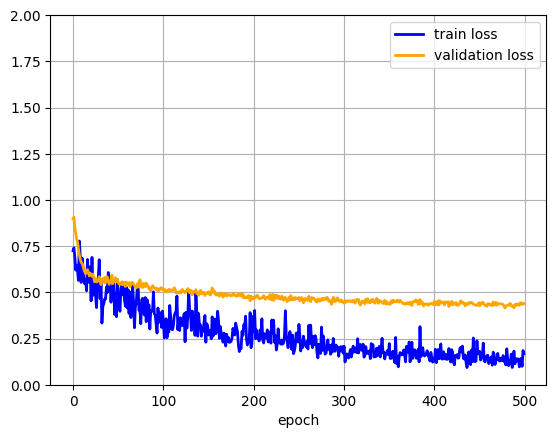

In [12]:
plot_data(loss_train, loss_val, 'train_loss', 'validation_loss')

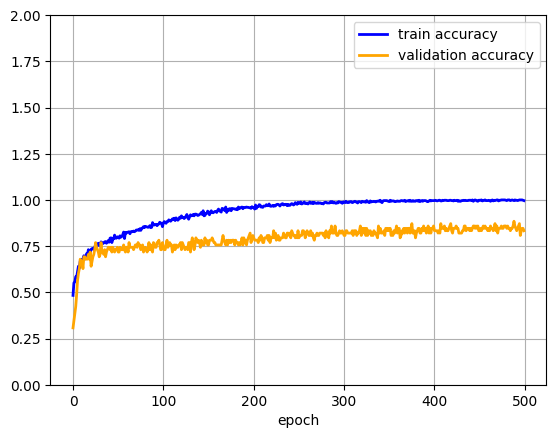

In [13]:
plot_data(acc_train, acc_val, 'train accuracy', 'validation accuracy')

In [ ]:
def validate_test_dataset():
    # Initialize progress bar for test loop
    test_loop = tqdm(test_loader, leave=True)

    # Set the model to evaluation mode
    ResNet18Model.eval()

    # Initialize variables for test loss, test accuracy, and total test samples
    test_loss = 0
    test_acc = 0
    total_test = 0

    # Initialize BinaryConfusionMatrix and confusion matrix tensor
    bcm = BinaryConfusionMatrix().to(device)
    conf_mat = torch.tensor([[0, 0], [0, 0]]).to(device)

    # Iterate over batches in the test loader
    for batch in test_loop:
        # Clear GPU cache
        torch.cuda.empty_cache()

        # Move input images and output classes to the device
        input_img = batch[0].to(device)
        out_class = batch[1].type(torch.LongTensor).to(device)

        # Perform forward pass
        output = ResNet18Model(input_img)

        # Calculate loss
        loss = loss_fn(output.contiguous().view(output.size(0), -1), out_class.view(-1))

        # Get predicted classes
        predicted = torch.argmax(output.data, dim=1)

        # Update total test samples count and test accuracy
        total_test += out_class.size(0)
        test_acc += (predicted == out_class.flatten()).sum().item()

        # Update confusion matrix
        conf_mat = bcm(predicted, out_class.flatten())

        # Update progress bar description and display loss and accuracy
        test_loop.set_description(f'Eval Epoch {1}')
        test_loop.set_postfix(loss=loss.item(), accuracy=(test_acc / total_test))

        # Update test loss
        test_loss = loss.item()
    return test_acc, total_test, test_loss, conf_mat

In [14]:
test_acc, total_test, test_loss, conf_mat = validate_test_dataset()

Eval Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s, accuracy=0.756, loss=0.513]


In [15]:
print( "accuracy: ", test_acc / total_test, "loss: ", test_loss)
print(conf_mat.data.cpu())

accuracy:  0.7564102564102564 loss:  0.5129542946815491
tensor([[ 12,  30],
        [  8, 106]])


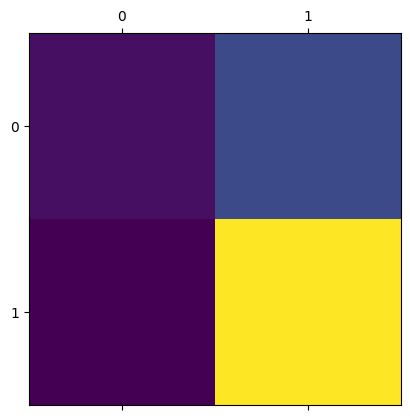

In [16]:
plt.matshow(conf_mat.data.cpu())

In [17]:
class cDCGAN_Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(cDCGAN_Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img,
                features_d,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(
                features_d,
                features_d*2, 4, 2, 1
            ),
            self._block(
                features_d*2,
                features_d*4, 4, 2, 1
            ),
            self._block(
                features_d*4,
                features_d*8, 4, 2, 1
            ),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.disc(x)

In [18]:
class cDCGAN_Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_G):
        super(cDCGAN_Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(
              z_dim,
              features_G*16, 4, 1, 0
            ),
            self._block(
              features_G*16,
              features_G*8, 4, 2, 1
            ),
            self._block(
              features_G*8,
              features_G*4, 4, 2, 1
            ),
            self._block(
              features_G*4,
              features_G*2, 4, 2, 1
            ),
            nn.ConvTranspose2d(
                features_G*2,
                channels_img,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.Tanh()
        )
    def _block(self, in_channels, out_channels, kernel_size, srtide, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                srtide,
                padding,
                bias=False
              ),
            nn.ReLU()
        )
    def forward(self, x):
        return self.gen(x)

In [19]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [20]:
def init_weights():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = cDCGAN_Discriminator(in_channels, 8)
    initialize_weights(disc)
    gen = cDCGAN_Generator(z_dim, in_channels, 8)
    z = torch.randn((N, z_dim, 1, 1))
    initialize_weights(disc)


In [ ]:
init_weights()

# Hyper Parameters

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LearningRate = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 500
FEATURES_DISC = 64
FEATURES_GEN  = 64

# Models

In [22]:
gen_model = cDCGAN_Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc_model = cDCGAN_Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# Initialize weights

In [ ]:
initialize_weights(gen_model)
initialize_weights(disc_model)

# Add Optimizers (Adam)

In [ ]:
opt_gen = optim.Adam(gen_model.parameters(), lr=LearningRate, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc_model.parameters(), lr=LearningRate, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [23]:
import torch
from tqdm import tqdm

def train_cGAN(gen, disc, opt_gen, opt_disc, criterion, epochs, train_loader):
    # Initialize lists to store losses for each epoch
    loss_d, loss_g = [], []

    # Loop over the specified number of epochs
    for epoch in range(epochs):
        # Set both the generator and discriminator to training mode
        gen.train()
        disc.train()

        # Create a progress bar for training batches
        train_loop = tqdm(train_loader, leave=True)

        # Initialize lists to store losses for each batch in the epoch
        g_losses, d_losses = [], []

        # Loop over the batches in the training data
        for images, labels in train_loop:
            # Move the real data and labels to the appropriate device (e.g., GPU)
            real_images = images.to(device)
            real_labels = labels.to(device)

            # Generate random noise for the generator input
            noise = torch.randn(real_images.size(0), Z_DIM, 1, 1).to(device)

            # Generate fake data using the generator with the corresponding labels
            fake_images = gen(noise, real_labels)

            # Concatenate real images with their corresponding labels
            real_data = torch.cat([real_images, real_labels], dim=1)

            # Concatenate fake images with their corresponding labels
            fake_data = torch.cat([fake_images, real_labels], dim=1)

            # Compute the discriminator's output and loss for real and fake data
            disc_real = disc(real_data).reshape(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake_data.detach()).reshape(-1)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

            # Combine the losses and compute the average for the discriminator
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

            # Zero out the gradients in the discriminator, backpropagate, and update the weights
            disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            # Concatenate fake images with their corresponding labels again for generator update
            fake_data = torch.cat([fake_images, real_labels], dim=1)

            # Compute the generator's output and loss
            output = disc(fake_data).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))

            # Zero out the gradients in the generator, backpropagate, and update the weights
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

            # Update the progress bar with the current loss values for the batch
            train_loop.set_description(f'Train Epoch {epoch}')
            train_loop.set_postfix(loss_D=loss_disc.item(), loss_G=loss_gen.item())

            # Store the losses for the current batch
            g_losses.append(loss_gen.item())
            d_losses.append(loss_disc.item())

        # Calculate and store the mean losses for the epoch
        loss_d.append(torch.mean(torch.FloatTensor(d_losses)))
        loss_g.append(torch.mean(torch.FloatTensor(g_losses)))

    # Return the lists of losses for all epochs
    return loss_d, loss_g

In [24]:
loss_d, loss_g = train_cDCGAN(gen_model, disc_model, opt_gen, opt_disc, criterion, NUM_EPOCHS, train_loader)

Train Epoch 499: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s, loss_D=0.133, loss_G=3.43]


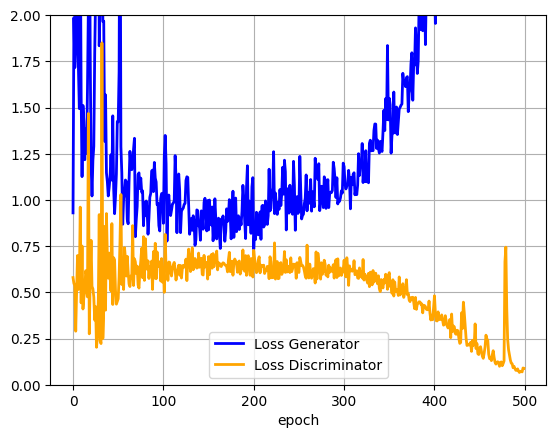

In [25]:
plot_data(loss_g, loss_d, "Loss Generator", "Loss Discriminator")

In [31]:
gen_model

cDCGAN_Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [9]:
fig, axs = plt.subplots(2, 5)
for i in range(40):
    axs[i//5][i%5].imshow(train_dataset[randomlist[i]][0].permute(1, 2, 0))

torch.Size([128, 3, 64, 64])
torch.Size([128, 1])
torch.Size([128, 3, 64, 64])
torch.Size([128, 1])
torch.Size([128, 3, 64, 64])
torch.Size([128, 1])
torch.Size([128, 3, 64, 64])
torch.Size([128, 1])
torch.Size([34, 3, 64, 64])
torch.Size([34, 1])


In [ ]:
# l_1 = list(filter(lambda x: x[1][0] == 1, train_dataset))
# fig, axs = plt.subplots(2, 5)

# for i in range(10):
#     axs[i//5][i%5].imshow(l_1[i][0].permute(1, 2, 0))

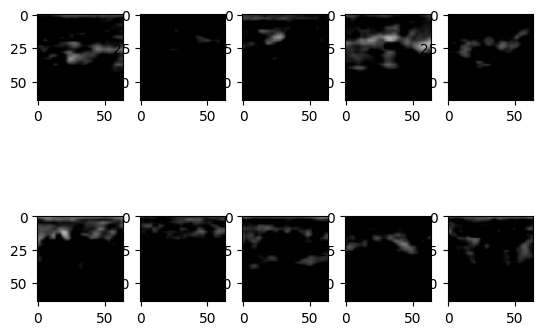

In [27]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_samples = 2000
batch_size = 64

random.seed(42)
torch.manual_seed(42)

generator.eval()
generated_samples = []
with torch.no_grad():
    for _ in range(num_samples // batch_size):

        noise = torch.randn(batch_size, latent_dim).to(device)  # Replace latent_dim with your latent dimension
        labels = torch.randint(0, num_classes, (batch_size,)).to(device)  # Replace num_classes with the number of classes

        samples = generator(noise, labels)
        generated_samples.append(samples.cpu())

generated_samples = torch.cat(generated_samples, dim=0)

random_indices = random.sample(range(generated_samples.shape[0]), k=10)
for index in random_indices:
    img = generated_samples[index]
    display_image(img)
